# DATA ANALYSIS

This script will serve to conduct analyses on the data we curated previously. We'll conduct our analyses as follows

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import string
import os
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm

In [67]:
# Let's load in the datasets that we curated previously

urban_v_rural = pd.read_csv('final_data/MO_stlouis_v_rural.csv')
demographics_by_case = pd.read_csv('final_data/Cases_by_demographic.csv')
demographics_by_deaths = pd.read_csv('final_data/Case_by_race.csv')
stlouis_econ_data = pd.read_csv('final_data/stlouis_covid_econ_data.csv')

First we'll plot the economic trend in St. Louis County over the course of the pandemic

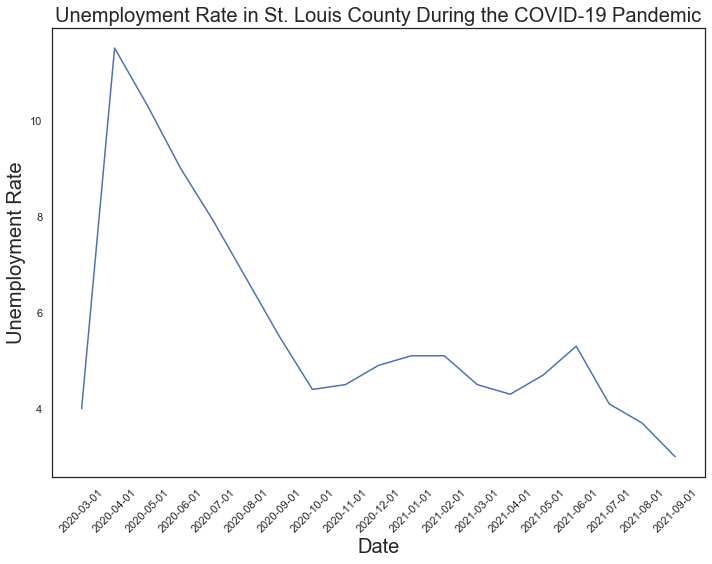

In [84]:
sns.set(style='white')

plt.plot(stlouis_econ_data['observation_date'], stlouis_econ_data['MOSLURN'], alpha=1)
plt.xticks(rotation = 45)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Unemployment Rate', fontsize = 20)
plt.title("Unemployment Rate in St. Louis County During the COVID-19 Pandemic", fontsize = 20)
plt.savefig("Unemployment.png", transparent = True)

Next we'll measure the daily percent increase in covid-related deaths over time in St. Louis County

C:\Users\mdbla\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


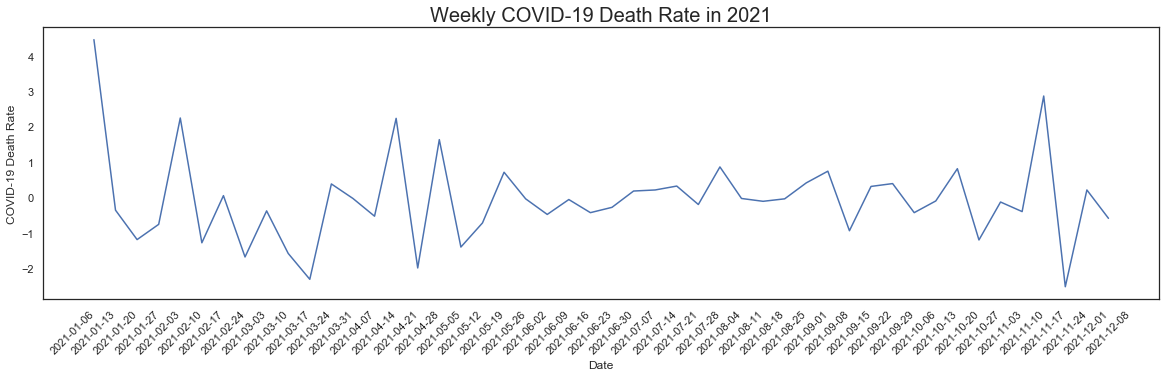

In [86]:
# Next the deaths over the time
st_louis_cases = urban_v_rural[urban_v_rural['county'] == 'St. Louis']

st_louis_cases['new_deaths'] = st_louis_cases.deaths_avg_per_100k.diff()
sns.set(style='white')

plt.figure(figsize=(20,5))
plt.plot(st_louis_cases['date'], st_louis_cases['new_deaths'], alpha=1)
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('COVID-19 Death Rate')
plt.title("Weekly COVID-19 Death Rate in 2021", fontsize = 20)
plt.savefig("Death_rate.png", transparent = True)

Now we'll look at our four counties and see how they compare to each other

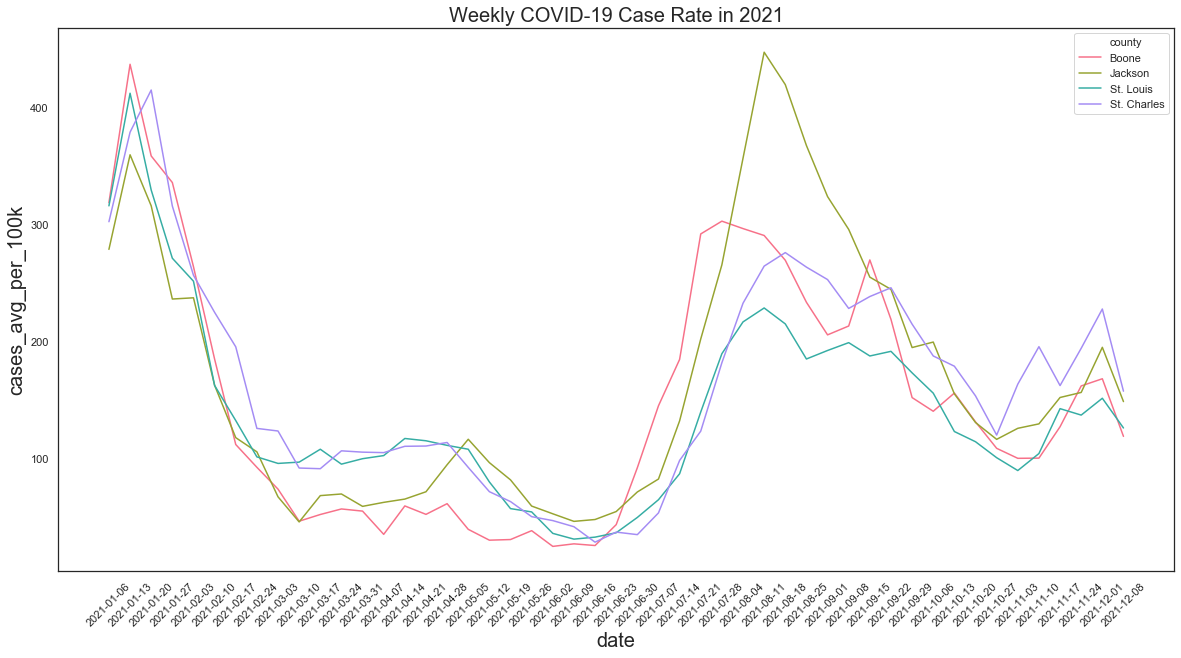

In [110]:
# First the Case rate
urban_v_rural['new_cases'] = urban_v_rural.cases_avg_per_100k.diff()

#colors = {'St. Louis':'blue', 'Boone':'black', 'Jackson':'green', 'St. Charles': 'red'}

counties = urban_v_rural['county'].unique()

colors = sns.color_palette('husl', n_colors=len(counties))  # get a number of colors

cmap = dict(zip(counties, colors))  # zip values to colors

# plot
sns.set(style='white')

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Average Cases per 100k', fontsize = 20)
plt.title("Weekly COVID-19 Case Rate in 2021", fontsize = 20)
sns.lineplot(x='date', y='cases_avg_per_100k', hue='county', data=urban_v_rural, palette=cmap)
plt.savefig("Case_rate_comparison.png", transparent = True)


#plt.figure(figsize=(20,5))
#plt.plot(urban_v_rural['date'], urban_v_rural['new_cases'], c = urban_v_rural['county'].map(colors) ,alpha=1)
#plt.xticks(rotation = 45)
#plt.xlabel('Date')
#plt.ylabel('COVID-19 Case Rate')
#plt.title("Weekly COVID-19 Case Rate in 2021", fontsize = 20)

In [96]:
# Now we'll perform Anova to see if there are differences between the four counties

from statsmodels.formula.api import ols

model = ols('cases_avg_per_100k ~ C(county)', data=urban_v_rural).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(county),2.110869e+04,3.0,0.737383,0.530922
Residual,1.832095e+06,192.0,NaN,NaN


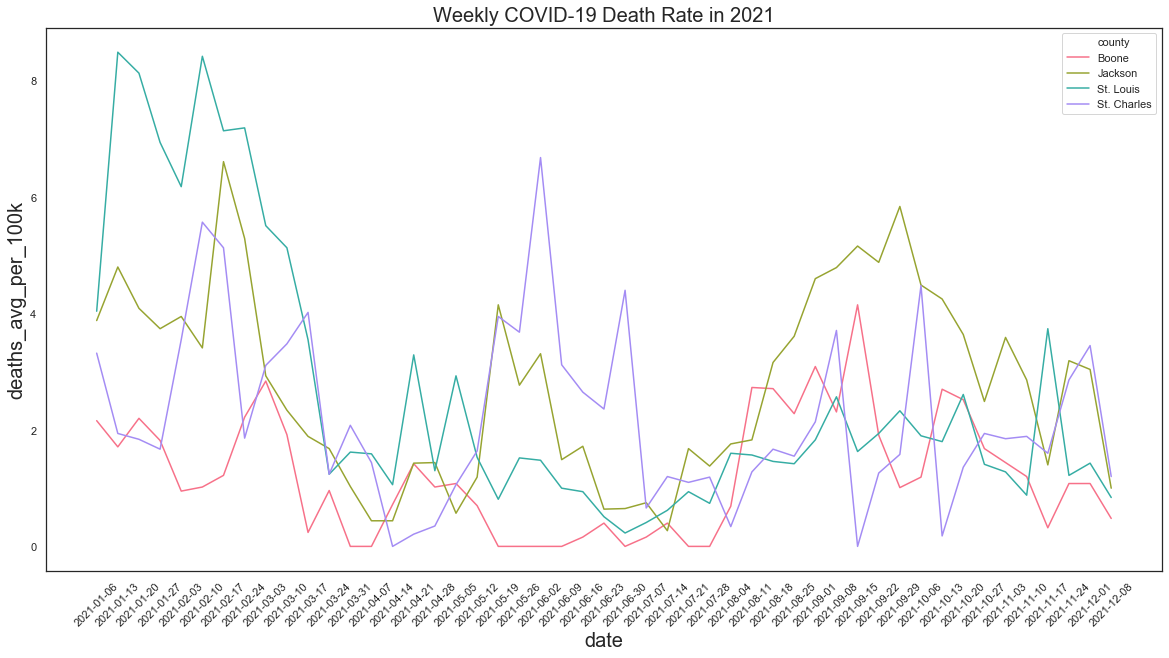

In [111]:
# Now the death rate 
urban_v_rural['new_deaths'] = urban_v_rural.deaths_avg_per_100k.diff()

#colors = {'St. Louis':'blue', 'Boone':'black', 'Jackson':'green', 'St. Charles': 'red'}

counties = urban_v_rural['county'].unique()

colors = sns.color_palette('husl', n_colors=len(counties))  # get a number of colors

cmap = dict(zip(counties, colors))  # zip values to colors

# plot
sns.set(style='white')

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Average Deaths per 100k', fontsize = 20)
plt.title("Weekly COVID-19 Death Rate in 2021", fontsize = 20)
sns.lineplot(x='date', y='deaths_avg_per_100k', hue='county', data=urban_v_rural, palette=cmap)
plt.savefig("final_data/Death_rate_comparison.png", transparent = True)

In [97]:
model = ols('deaths_avg_per_100k ~ C(county)', data=urban_v_rural).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(county),70.843304,3.0,8.339845,0.000031
Residual,543.651792,192.0,NaN,NaN


We see that there is a significant difference in the COVID-19 death rate among the four counties. This requires post-hoc analysis

In [103]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=urban_v_rural['deaths_avg_per_100k'],
                          groups=urban_v_rural['county'],
                          alpha=0.05)

print(tukey)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
      Boone     Jackson   1.5439  0.001  0.6628  2.425   True
      Boone St. Charles    0.999 0.0192  0.1179 1.8801   True
      Boone   St. Louis   1.3888  0.001  0.5077 2.2699   True
    Jackson St. Charles  -0.5449 0.3804  -1.426 0.3362  False
    Jackson   St. Louis  -0.1551    0.9 -1.0362  0.726  False
St. Charles   St. Louis   0.3898 0.6425 -0.4913 1.2709  False
-------------------------------------------------------------


Now let's look at the demographic datasets to gain a better perspective as to which demographics were more vulnerable to covid.

First, we'll look at Cases v. Age and Sex

In [91]:
demographics_by_case.head(10)

,Sex,Age Group,Cases,Case_Rate
0,Female,0-9,910,5136.9
1,Female,10-19,1490,9242.6
2,Female,20-29,4117,14317.5
3,Female,30-39,3478,13546.8
4,Female,40-49,2386,12875.7
5,Female,50-59,2130,10376.1
6,Female,60-69,1676,9406.2
7,Female,70-79,769,8519.8
8,Female,80+,530,8063.3
9,Male,0-9,908,5066.1


Text(0, 0.5, 'Cases per 100k people')

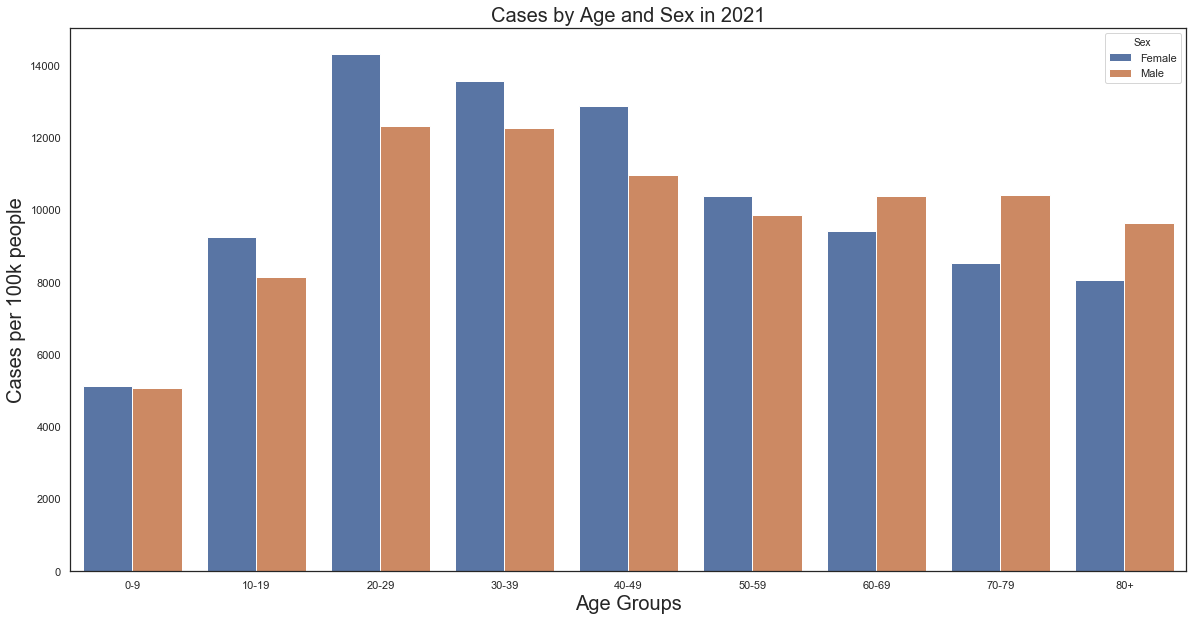

In [107]:
#demographics_by_case.head(20)

sns.set(style='white')

plt.figure(figsize=(20, 10))
sns.barplot(x=demographics_by_case['Age Group'], y=demographics_by_case['Case_Rate'], hue=demographics_by_case['Sex'])
plt.title('Cases by Age and Sex in 2021', fontsize = 20)
plt.xlabel('Age Groups', fontsize = 20)
plt.ylabel('Cases per 100k people', fontsize = 20)
plt.savefig("final_data/Cases_by_age_and_sex.png", transparent = True)

Now we'll look at Cases v. Age and Race

Text(0, 0.5, 'Cases per 100k')

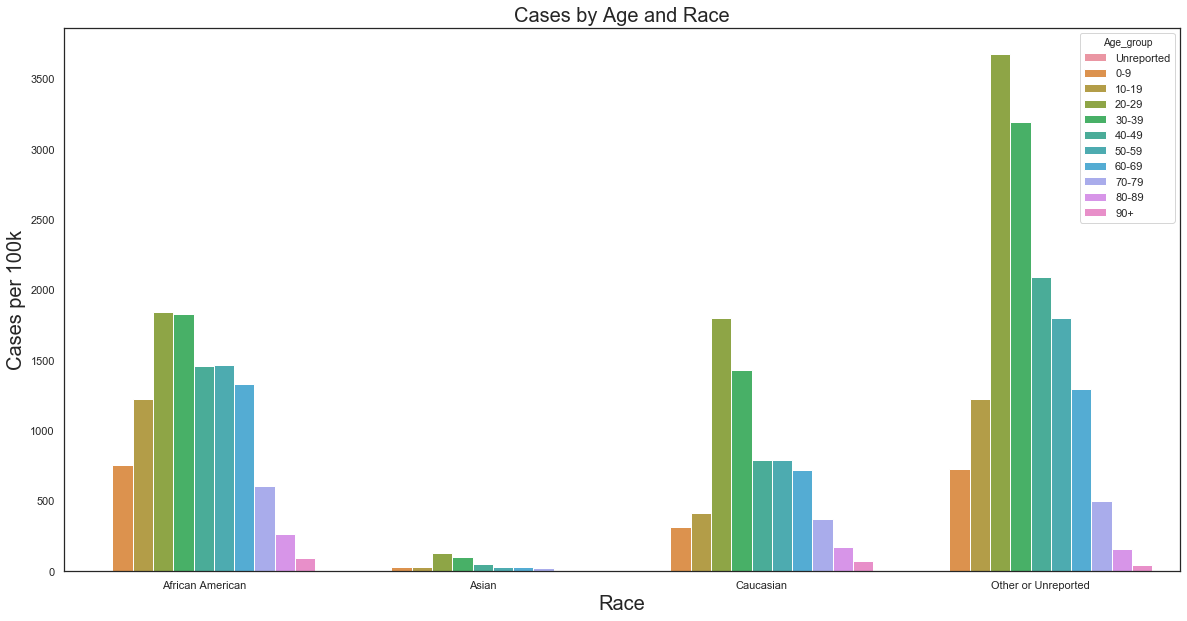

In [109]:
sns.set(style='white')

plt.figure(figsize=(20, 10))
sns.barplot(x=demographics_by_deaths['Race'], y=demographics_by_deaths['Cases'], hue=demographics_by_deaths['Age_group'])
plt.title('Cases by Age and Race', fontsize = 20)
plt.xlabel('Race', fontsize = 20)
plt.ylabel('Cases per 100k', fontsize = 20)
plt.savefig("final_data/Cases_by_age_and_race.png", transparent = True)